# PyTorch qGAN Implementation

### Description
A PyTorch-based Quantum Generative Adversarial Network algorithm.

The qGAN \[1\] is a hybrid quantum-classical algorithm used for generative modeling tasks. The algorithm uses the interplay of a quantum generator $G_{\theta}$, i.e., an ansatz, and a classical discriminator $D_{\phi}$, a neural network. to learn the probability distribution underlying given training data.

The generator and discriminator are trained in alternating optimization steps, where the generator aims at generating samples which the discriminator classifies as training data samples and the discriminator tries to differentiate between training data samples and data samples from the generator. The final goal is for the quantum generator to learn a representation for the training data's underlying probability distribution.
The trained quantum generator can, thus, be used to load a quantum state which is an approximate model of the target distribution.

**References:**

\[1\] Zoufal et al., [Quantum Generative Adversarial Networks for learning and loading random distributions](https://www.nature.com/articles/s41534-019-0223-2)

### Application: qGANs for Loading Random Distributions

Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$.

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043) _Zoufal, Lucchi, Woerner_ \[2019\].

For an example of how to use a trained qGAN in an application, the pricing of financial derivatives, please see the
[Option Pricing with qGANs](https://github.com/Qiskit/qiskit-finance/tree/main/docs/tutorials/10_qgan_option_pricing.ipynb) tutorial.

In [2]:
from typing import Union, List, Iterable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import Gradient, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from scipy.stats import entropy
from torch.optim import Adam
from torch.utils.data import DataLoader

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.datasets.dataset_helper import discretize_and_truncate
from qiskit_machine_learning.neural_networks import CircuitQNN

# Set seed for random generators
algorithm_globals.random_seed = 42
torch.manual_seed(42)
np.random.seed = 42

### Data and Representation

First, we need to load our training data $X$.

In this tutorial, the training data is given by samples from a 2D multivariate normal distribution.

The trained generator corresponds to an $n$-qubit quantum state
\begin{equation}
|g_{\text{trained}}\rangle=\sum\limits_{j=0}^{k-1}\sqrt{p_{j}}|x_{j}\rangle,
\end{equation}
where the basis states $|x_{j}\rangle$ represent the data items in the training data set
$X={x_0, \ldots, x_{k-1}}$ with $k\leq 2^n$ and $p_j$ refers to the sampling probability
of $|x_{j}\rangle$.

To facilitate this representation, we need to map the samples from the multivariate
normal distribution to discrete values. The number of values that can be represented
depends on the number of qubits used for the mapping.
Hence, the data resolution is defined by the number of qubits.
If we use $3$ qubits to represent one feature, we have $2^3 = 8$ discrete values.

In [3]:
# Load the training data
training_data = np.random.default_rng().multivariate_normal(
    mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], size=1000, check_valid="warn", tol=1e-8, method="svd"
)
# Define minimal and maximal values for the training data
bounds_min = np.percentile(training_data, 5, axis=0)
bounds_max = np.percentile(training_data, 95, axis=0)
bounds = []
for i, _ in enumerate(bounds_min):
    bounds.append([bounds_min[i], bounds_max[i]])

# Determine data resolution for each dimension of the training data in terms
# of the number of qubits used to represent each data dimension.
data_dim = [3, 3]

# Pre-processing, i.e., discretization of the data (gridding)
(training_data, _, grid_elements, prob_data) = discretize_and_truncate(
    training_data,
    np.asarray(bounds),
    data_dim,
    return_data_grid_elements=True,
    return_prob=True,
    prob_non_zero=True,
)

We convert numpy arrays into tensors and create a data loader from our training data.

In [4]:
training_data = torch.tensor(training_data, dtype=torch.float)
grid_elements = torch.tensor(grid_elements, dtype=torch.float)

# Define the training batch size
batch_size = 300
dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)

### Specify Backend
Next, we need to choose a backend that is used to run the quantum generator.
The presented method is compatible with all shot-based backends (qasm, fake hardware, real hardware) provided by Qiskit.

In [5]:
backend = Aer.get_backend("aer_simulator")
#Quantum Instance for the training where the batch size defines the number of shots
qi = QuantumInstance(backend, shots=batch_size)
#Quantum Instance for the evaluation we choose a higher number of shots to get better insights
qi_sampling = QuantumInstance(backend, shots=10000)

### Initialization of quantum generator and the respective gradient
Next, we define factories that create the quantum generator and a function that calculates the gradients for the quantum generator.
Depending on the backend, the latter may be returned in a sparse format. Since PyTorch does not support sparse gradients, we need to write a custom function for gradient based training.


In [6]:
def create_generator(
    qnn: QuantumCircuit,
    parameters: Union[ParameterVector, ParameterExpression, List[ParameterExpression]],
    qinstance: QuantumInstance
) -> TorchConnector:
    """
    Factory to create the quantum generator from a given parameterized quantum circuit.
    Args:
        qnn: Quantum neural network ansatz given as a quantum circuit.
        parameters: The parameters of the quantum neural network which are trained.
        qinstance: The quantum instance used to run the quantum generator.
    Returns:
        Quantum neural network compatible with PyTorch
    """
    circuit_qnn = CircuitQNN(
        qnn,
        input_params=[],
        weight_params=parameters,
        quantum_instance=qinstance,
        sampling=True,
        sparse=False,
        input_gradients=True,
        interpret=lambda x: grid_elements[x],
    )
    # We use the Qiskit TorchConnector to ensure compatibility with PyTorch
    return TorchConnector(circuit_qnn)


def generator_grad(
    qnn: QuantumCircuit,
    parameters: Union[ParameterVector, ParameterExpression, List[ParameterExpression]],
    param_values: Iterable,
) -> Iterable:
    """
    The function returns the gradient values for the quantum generator given the
    underlying parameterized quantum circuit.
    Args:
        qnn: Quantum neural network ansatz given as a quantum circuit.
        parameters: The parameters of the quantum neural network which are trained.
        param_values: The current values of the quantum neural network parameters.
    Returns:
        List of gradients for the sampling probabilities of the quantum neural network.
    """
    grad = Gradient().gradient_wrapper(StateFn(qnn), parameters, backend=qi)
    grad_values = grad(param_values)
    return grad_values.tolist()

### Definition of classical discriminator
Next, we define factories that create the classical discriminators. The underlying gradients can be automatically computed with PyTorch.

In [7]:
class create_discriminator(nn.Module):
    """
    Factory to create the quantum generator from a given parameterized quantum circuit.
    """

    def __init__(self):
        super(create_discriminator, self).__init__()

        self.Linear_in = nn.Linear(len(data_dim), 20)
        self.Leaky_ReLU = nn.LeakyReLU(0.2, inplace=True)
        # self.Linear50 = nn.Linear(50, 20)
        self.Linear20 = nn.Linear(20, 1)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.Linear_in(input)
        x = self.Leaky_ReLU(x)
        # x = self.Linear50(x)
        # x = self.Leaky_ReLU(x)
        x = self.Linear20(x)
        x = self.Sigmoid(x)
        return x

### Initialize the quantum neural network ansatz

Now, we are ready to define the parameterized quantum circuit $G\left(\boldsymbol{\theta}\right)$ with $\boldsymbol{\theta} = {\theta_1, ..., \theta_k}$ which corresponds to our quantum generator.

To implement the quantum generator, we choose a depth-$2$ ansatz that implements $R_Y$ rotations and $CX$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be $>1$ because higher circuit depths enable the representation of more complex structures.


In [8]:
# sum(data_dim) corresponds to the total number of qubits in our quantum circuit (qc)
qc = QuantumCircuit(sum(data_dim))
qc.h(qc.qubits)
# We choose a hardware efficient ansatz.
twolocal = TwoLocal(sum(data_dim), "ry", "cx", reps=2, entanglement="sca")
qc.compose(twolocal, inplace=True)

### Definition of the loss functions
We want to train the generator and the discriminator with binary cross entropy as loss function:
$$L\left(\boldsymbol{\theta}\right)=\sum_jp_j\left(\boldsymbol{\theta}\right)\left[y_j\log(x_j) + (1-y_j)\log(1-x_j)\right],$$
where $x_j$ refers to a data sample and $y_j$ to the corresponding label.

In [9]:
# Generator loss function
gen_loss_fun = nn.BCELoss()
# Discriminator loss function
disc_loss_fun = nn.BCELoss()

### Evaluation of custom gradients for the generator BCE loss function
The evaluation of custom gradients for the quantum generator requires us to combine quantum gradients $\frac{\partial p_j\left(\boldsymbol{\theta}\right)}{\partial \theta_l}$ that we compute with Qiskit's gradient framework with the binary cross entropy as follows:
$$\frac{\partial L\left(\boldsymbol{\theta}\right)}{\partial \theta_l} = \sum_j \frac{\partial p_j\left(\boldsymbol{\theta}\right)}{\partial \theta_l} \left[y_j\log(x_j) + (1-y_j)\log(1-x_j)\right].$$

In [10]:
def g_loss_fun_grad(
    qnn: QuantumCircuit,
    parameters: Union[ParameterVector, ParameterExpression, List[ParameterExpression]],
    param_values: Iterable,
    discriminator_: nn.Module,
) -> Iterable:
    """
    Custom gradient of the generator loss function considering the custom gradients of the quantum generator
    Args:
        qnn: Quantum neural network ansatz given as a quantum circuit.
        parameters: The parameters of the quantum neural network which are trained.
        param_values: The current values of the quantum neural network parameters.
        discriminator_: Classical neural network representing the discriminator.
    Returns:
        List of gradient values, i.e., the gradients of the loss function w.r.t. the quantum neural network parameters
    """
    grads = generator_grad(qnn, parameters, param_values)
    loss_grad = ()
    for j, grad in enumerate(grads):
        cx = grad[0].tocoo()
        input = torch.zeros(len(cx.col), 2)
        target = torch.ones(len(cx.col), 1)
        weight = torch.zeros(len(cx.col), 1)

        for i, (index, prob_grad) in enumerate(zip(cx.col, cx.data)):
            input[i, :] = grid_elements[index]
            weight[i, :] = prob_grad
        bce_loss_grad = F.binary_cross_entropy(discriminator_(input), target, weight)
        loss_grad += (bce_loss_grad,)
    loss_grad = torch.stack(loss_grad)
    return loss_grad

### Relative entropy as benchmarking metric
The relative entropy describes a distance metric for distributions. Hence, we can use it to benchmark how close/far away the trained distribution is from the target distribution.

In [11]:
def get_relative_entropy(gen_data) -> float:
    """Get relative entropy between target and trained distribution"""
    prob_gen = np.zeros(len(grid_elements))
    for j, item in enumerate(grid_elements):
        for gen_item in gen_data.detach().numpy():
            if np.allclose(np.round(gen_item, 6), np.round(item, 6), rtol=1e-5):
                prob_gen[j] += 1
    prob_gen = prob_gen / len(gen_data)
    prob_gen = [1e-8 if x == 0 else x for x in prob_gen]
    rel_entr = entropy(prob_gen, prob_data)
    return rel_entr

### Definition of the optimizers
In order to train the generator and discriminator, we need to define optimization schemes. In the following, we employ a momentum based optimizer called Adam, see [Kingma et al., Adam: A method for stochastic optimization](https://arxiv.org/abs/1412.6980) for more details.

In [12]:
# Initialize generator and discriminator
generator = create_generator(qc, twolocal.parameters, qi)
discriminator = create_discriminator()

lr = 0.01  # learning rate
b1 = 0.9  # first momentum parameter
b2 = 0.999  # second momentum parameter
n_epochs = 250 # number of training epochs

# optimizer for the generator
optimizer_G = Adam(generator.parameters(), lr=lr, betas=(b1, b2))
# optimizer for the discriminator
optimizer_D = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

### Training
Now, we are ready to train our model.

In [13]:
# Relative entropy list
rel_entr_list = []
# Generator loss list
g_loss_list = []
# Discriminator loss list
d_loss_list = []

for epoch in range(n_epochs):
    rel_entr = []
    g_loss_ = []
    d_loss_ = []
    for i, data in enumerate(dataloader):
        # Adversarial ground truths
        # valid = Variable(Tensor(data.size(0), 1).fill_(1.0), requires_grad=False)
        valid = torch.ones(data.size(0), 1)
        # fake = Variable(Tensor(data.size(0), 1).fill_(0.0), requires_grad=False)
        fake = torch.zeros(data.size(0), 1)

        # Configure input
        # real_data = Variable(data.type(Tensor))
        real_data = data
        # Generate a batch of data points
        gen_data = generator()

        # Evaluate Relative Entropy
        rel_entr.append(get_relative_entropy(gen_data))

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss measures discriminator's ability to distinguish real from generated samples
        disc_data = discriminator(real_data)
        real_loss = disc_loss_fun(disc_data, valid)
        fake_loss = disc_loss_fun(discriminator(gen_data), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Loss measures generator's ability to prepare good data samples
        g_loss = gen_loss_fun(discriminator(gen_data), valid)
        g_loss.retain_grad = True
        g_loss_grad = g_loss_fun_grad(
            qc, twolocal.ordered_parameters, generator.weight.data.numpy(), discriminator
        )

        g_loss.backward(retain_graph=True)
        for j, param in enumerate(generator.parameters()):
            param.grad = g_loss_grad
        optimizer_G.step()

        g_loss_.append(g_loss.item())
        d_loss_.append(d_loss.item())

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

    rel_entr_list.append(np.mean(rel_entr))
    g_loss_list.append(np.mean(g_loss_))
    d_loss_list.append(np.mean(d_loss_))

[Epoch 0/250] [Batch 0/2] [D loss: 0.700965] [G loss: 0.647841]
[Epoch 0/250] [Batch 1/2] [D loss: 0.688820] [G loss: 0.692263]
[Epoch 1/250] [Batch 0/2] [D loss: 0.674126] [G loss: 0.732674]
[Epoch 1/250] [Batch 1/2] [D loss: 0.667802] [G loss: 0.759466]
[Epoch 2/250] [Batch 0/2] [D loss: 0.652979] [G loss: 0.804434]
[Epoch 2/250] [Batch 1/2] [D loss: 0.655400] [G loss: 0.833225]
[Epoch 3/250] [Batch 0/2] [D loss: 0.652123] [G loss: 0.844781]
[Epoch 3/250] [Batch 1/2] [D loss: 0.640498] [G loss: 0.894816]
[Epoch 4/250] [Batch 0/2] [D loss: 0.639994] [G loss: 0.906813]
[Epoch 4/250] [Batch 1/2] [D loss: 0.635819] [G loss: 0.914962]
[Epoch 5/250] [Batch 0/2] [D loss: 0.645992] [G loss: 0.917872]
[Epoch 5/250] [Batch 1/2] [D loss: 0.625612] [G loss: 0.954626]
[Epoch 6/250] [Batch 0/2] [D loss: 0.642760] [G loss: 0.945325]
[Epoch 6/250] [Batch 1/2] [D loss: 0.657487] [G loss: 0.899798]
[Epoch 7/250] [Batch 0/2] [D loss: 0.637634] [G loss: 0.929529]
[Epoch 7/250] [Batch 1/2] [D loss: 0.641

### Plots
Let's visualize what happened during the training by plotting the evolution of the generator's and the discriminator's loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution.

Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

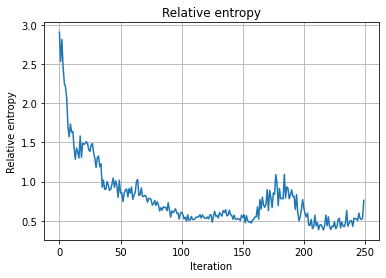

In [14]:
# Relative Entropy
plt.figure()
plt.title("Relative entropy")
plt.plot(rel_entr_list)
plt.xlabel("Iteration")
plt.ylabel("Relative entropy")
plt.grid()
plt.show()

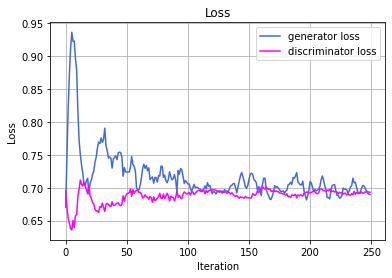

In [15]:
# Loss
plt.figure()
plt.title("Loss")
plt.plot(g_loss_list, label="generator loss", color="royalblue")
plt.plot(d_loss_list, label="discriminator loss", color="magenta")
plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [16]:
# Get a generator for sampling which takes more shots and, hence, gives more information
generator_sampling = create_generator(qc, twolocal.parameters, qi_sampling)
generator_sampling.weight.data = generator.weight.data

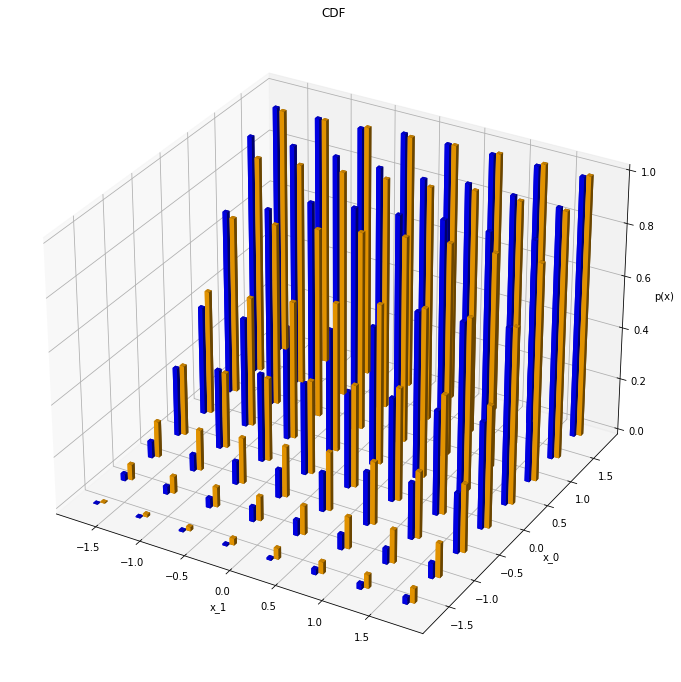

In [17]:
# CDF
# Get the generator data samples and corresponding sampling probabilities
gen_data = generator_sampling().detach().numpy()
prob_gen = np.zeros(len(grid_elements))
for j, item in enumerate(grid_elements):
    for gen_item in gen_data:
        if np.allclose(np.round(gen_item, 6), np.round(item, 6), rtol=1e-5):
            prob_gen[j] += 1
prob_gen = prob_gen / len(gen_data)

prob_gen = [1e-8 if x == 0 else x for x in prob_gen]
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection="3d")
ax1.set_title("CDF")
# TODO add legend - known issue with matplotlib unresolved
ax1.bar3d(
    np.transpose(grid_elements)[1],
    np.transpose(grid_elements)[0],
    np.zeros(len(prob_gen)),
    0.05,
    0.05,
    np.cumsum(prob_gen),
    label="generated data",
    color="blue",
    alpha=1,
)
ax1.bar3d(
    np.transpose(grid_elements)[1]+0.05,
    np.transpose(grid_elements)[0]+0.05,
    np.zeros(len(prob_data)),
    0.05,
    0.05,
    np.cumsum(prob_data),
    label="training data",
    color="orange",
    alpha=1,
)
# ax1.legend(loc='upper right')
ax1.set_xlabel("x_1")
ax1.set_ylabel("x_0")
ax1.set_zlabel("p(x)")
plt.show()


<span style="color:blue">Generated data</span>
<span style="color:orange">Training data</span>

In [18]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright
